In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.preprocessing import RobustScaler, MinMaxScaler

from preprocessing_utils import ThreeMonthReturn, CreateSequences, SplitData, FindNearestDateIndex, DataFrame_to_Tensors

In [58]:
# Initializations

# set device
pytorch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set seed
def assert_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

assert_seed(42)

##### **Load in the data**

In [8]:
raw_stock_data = pd.read_csv('data/SP500_stock_prices_cleaned_with_3month_return.csv', index_col=0, parse_dates=True)
stock_tickers = pd.Series(raw_stock_data.Ticker.unique())

#### **Preprocess the dataframe**
Turn the dataframe into the ticker dictionary of feature and target tensors

1. scale entire dataset based on the training/test split - dont split yet tho.
2. when the whole dataset is scaled, we just use our normal functions for splitting and creating sequences
5. Create a dataset of sequences. 
6. fit the scaler on the original 2D dataset's training split
7. transform all of the sequences needed according to that split's scaler. (Can we scale tensors with minmaxscaler?)

Ideas:
From GPT: we can just append the data that was used for testing and now are part of the training set to a "history" of data, a.k.a, the dataset.
It means we probably need a function for the training of the model so its not as overwhelming looking at the training loop.


In [9]:
# change doubles/64 bit floats into 32bit floats
float_cols = list(raw_stock_data.select_dtypes(include=['float64', 'int64']))  # replace with your float column names
raw_stock_data[float_cols] = raw_stock_data[float_cols].astype('float32')

In [77]:
# Initialize a dictionary to store the scalers
scalers = {}

scaled_stock_data = raw_stock_data.copy()

# Iterate over each ticker
for ticker in stock_tickers:
    # Extract the rows corresponding to the current ticker
    ticker_rows_train = raw_stock_data[raw_stock_data['Ticker'] == ticker][:'2019-06-30'].copy()
    ticker_rows_test = raw_stock_data[raw_stock_data['Ticker'] == ticker]['2019-7-01':].copy()
    
    # Extract the numerical columns to be scaled
    numerical_columns = ticker_rows_train.drop(columns=['Ticker', 'Sector']).columns  # Assuming the ticker column is the first column
    
    # Initialize the scaler
    scaler = MinMaxScaler()
    
    # Fit and transform the numerical columns for the current ticker
    ticker_rows_train[numerical_columns] = scaler.fit_transform(ticker_rows_train[numerical_columns])
    ticker_rows_test[numerical_columns] = scaler.transform(ticker_rows_test[numerical_columns])

    # concatenate the scaled rows horizontally
    ticker_rows = pd.concat([ticker_rows_train, ticker_rows_test], axis=0)

    
    # Store the scaler in the dictionary
    scalers[ticker] = scaler

    # Update the scaled rows in the original dataframe
    scaled_stock_data[scaled_stock_data['Ticker'] == ticker] = ticker_rows


In [78]:
# create the data sequences for each stock ticker.
# we make 
data_sequences_dict = {}
for ticker in stock_tickers:
    # print(ticker)
    df = scaled_stock_data[scaled_stock_data['Ticker'] == ticker].drop(columns=['Ticker', 'Sector'])
    data_sequences_dict[ticker] = DataFrame_to_Tensors(df.iloc[63:], split_date='2019-7-01') #TODO: include pre-2016 data, to not drop 63 rows

#### Training and test split functions

## **Building the model**

#### *Data processing*


In [13]:
# Dataset sctructure
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
def fetchDataLoader(ticker_sequences_dict, batch_size=16, num_workers=0):
    # Initialize the datasets
    train_dataset = TimeSeriesDataset(ticker_sequences_dict['train_features'], ticker_sequences_dict['train_targets'])
    # val_dataset = TimeSeriesDataset(ticker_sequences_dict['val_features'], ticker_sequences_dict['val_targets'])
    test_dataset = TimeSeriesDataset(ticker_sequences_dict['test_features'], ticker_sequences_dict['test_targets'])

    # Initialize the dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    # val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    return train_dataloader, test_dataloader


In [30]:
# example usage
train_loader, test_loader = fetchDataLoader(data_sequences_dict['AAPL'], batch_size=16, num_workers=0)

In [17]:
# TODO: remove the sequences that have NaN values in them...
# TODO: maybe get the 3 months on the other side of the 2016-01-04 date, 
# TODO: to compute the 3 month return for the earliest date in the dataset.
# for now we just cut it off at 2016-04-01, where the sequence doesnt contain any NaN values.

#### *Model architecture*

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout_rate):
        super(LSTM, self).__init__()
        
        # Define the dimensions of the LSTM layer
        self.hidden_dim = hidden_layer_size
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # fc output layer
        self.fc = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        # Init hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        dropout_out = self.dropout(out)
        
        # Decode the last generated hidden state
        pred = self.fc(dropout_out[:, -1, :])

        return pred.squeeze() # single dimension output




#### *Setup the model trainer*

In [34]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler,
                num_epochs=50, n_epochs_stop=10, min_val_loss=np.Inf, epochs_no_improve=0, model_save=True, verbose=True):
    
    epoch_val_losses = []
    epoch_train_losses = []

    for epoch in range(num_epochs):
        model.train()  # set the model to training mode

        train_losses = []
        for batch_X, batch_y in train_loader:
            # move data to GPU if available
            batch_X = batch_X.to(pytorch_device)
            batch_y = batch_y.to(pytorch_device)

            # forward propagation
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # backward propagation
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # save losses
            train_losses.append(loss.item())

        # calculate average losses
        train_loss = np.mean(train_losses)
        epoch_train_losses.append(train_loss)
        
        # Validation
        model.eval()  # set the model to evaluation mode

        val_losses = []
        with torch.no_grad():
            for X_val_batch, y_val_batch in test_loader:
                val_outputs = model(X_val_batch.to(pytorch_device))
                val_loss = criterion(val_outputs, y_val_batch.to(pytorch_device)).item()
                val_losses.append(val_loss)

        val_loss = np.mean(val_losses)
        epoch_val_losses.append(val_loss)

        # print progress
        if epoch % 5 == 0 and verbose:
            print(f"Epoch {epoch+1}/{num_epochs}.. Train loss: {train_loss:.3f}, Validation loss: {val_loss:.3f}")

        # check if validation loss has decreased (significantly)
        if val_loss < min_val_loss and abs(min_val_loss - val_loss) > 0.001:

            if model_save == True:
                print(f'Validation loss decreased ({min_val_loss:.3f} --> {val_loss:.3f}).  Saving model ...') if verbose else None
                torch.save(model.state_dict(), 'model.pt')
                torch.save(optimizer.state_dict(), 'optimizer.pt')

            epochs_no_improve = 0
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1
            # check if early stopping conditions are met
            if epochs_no_improve == n_epochs_stop:
                print('Early stopping!')
                break

        # step the scheduler
        scheduler.step(val_loss)

    return epoch_train_losses, epoch_val_losses, min_val_loss

##### *Defining model hyperparameters, dataloaders and training utilities*

In [44]:
# based on a paper.: See notion.
# important difference is 2 layers with dropout between them. 
# paper mentions 1 layer and dropout, but that is atypical apparantly. We can try with a manual dropout layer.

input_size = 6
hidden_layer_size = 32
num_layers = 1
output_size = 1
dropout_rate = 0.4

model = LSTM(input_size, hidden_layer_size, num_layers, output_size, dropout_rate)
model.to(pytorch_device)
print(model)

criterion = nn.MSELoss()

# Well rounded, and doesnt need much fine-tuning.
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early stopping details
n_epochs_stop = 10
min_val_loss = np.Inf
epochs_no_improve = 0

# Epochs
num_epochs = 50

LSTM(
  (lstm): LSTM(6, 32, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [79]:
train_loader, test_loader = fetchDataLoader(data_sequences_dict['F'], batch_size=16, num_workers=0)

#### *Single ticker training*

In [80]:
assert_seed(42)

# train tha model
epoch_train_losses, epoch_val_losses, min_val_loss = train_model(model=model, 
                                                                 train_loader=train_loader, test_loader=test_loader, 
                                                                 criterion=criterion, optimizer=optimizer, scheduler=scheduler, 
                                                                 num_epochs=num_epochs,
                                                                 model_save=True, verbose=True)

Epoch 1/50.. Train loss: 0.088, Validation loss: 0.042
Validation loss decreased (inf --> 0.042).  Saving model ...
Epoch 6/50.. Train loss: 0.083, Validation loss: 0.042
Epoch 11/50.. Train loss: 0.080, Validation loss: 0.042
Early stopping!


In [ ]:
"""
Folder structure for model saving:
models/
    MMM/
        model.pt
        optimizer.pt
        model_losses.json
        model_params.json
    AAPL/
        model.pt
        optimizer.pt
        .
        .
    F/
    .
    .

"""

### **Big training loop**
Below we will train all 500 models and save interesting parameters and metrics.  

We use the validation loss as a proxy of their generalization.  
As of now, they only train on 1 period. (implementing walk-forward validation, we will be able to say more about the robustness of its performance)  
Likewise, using a testing period we will have our final generalization metrics.

In [ ]:
"""

...hyperparameters


for ticker in stock_tickers:

    # init model
    model = LSTM(input_size, hidden_layer_size, num_layers, output_size, dropout_rate)
    
    data_load(data[period], ticker)

    train_losses, val_losses, min_val_loss = train_model(model)




"""

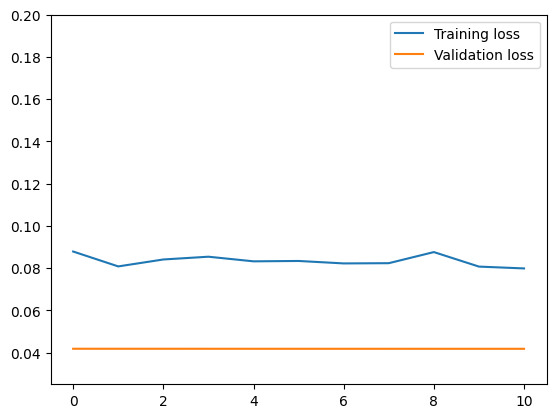

In [81]:
# plot the moodel loss and validation loss in the same figure
plt.plot(epoch_train_losses, label='Training loss')
plt.plot(epoch_val_losses, label='Validation loss')
plt.ylim(0.025, 0.2)
plt.legend()

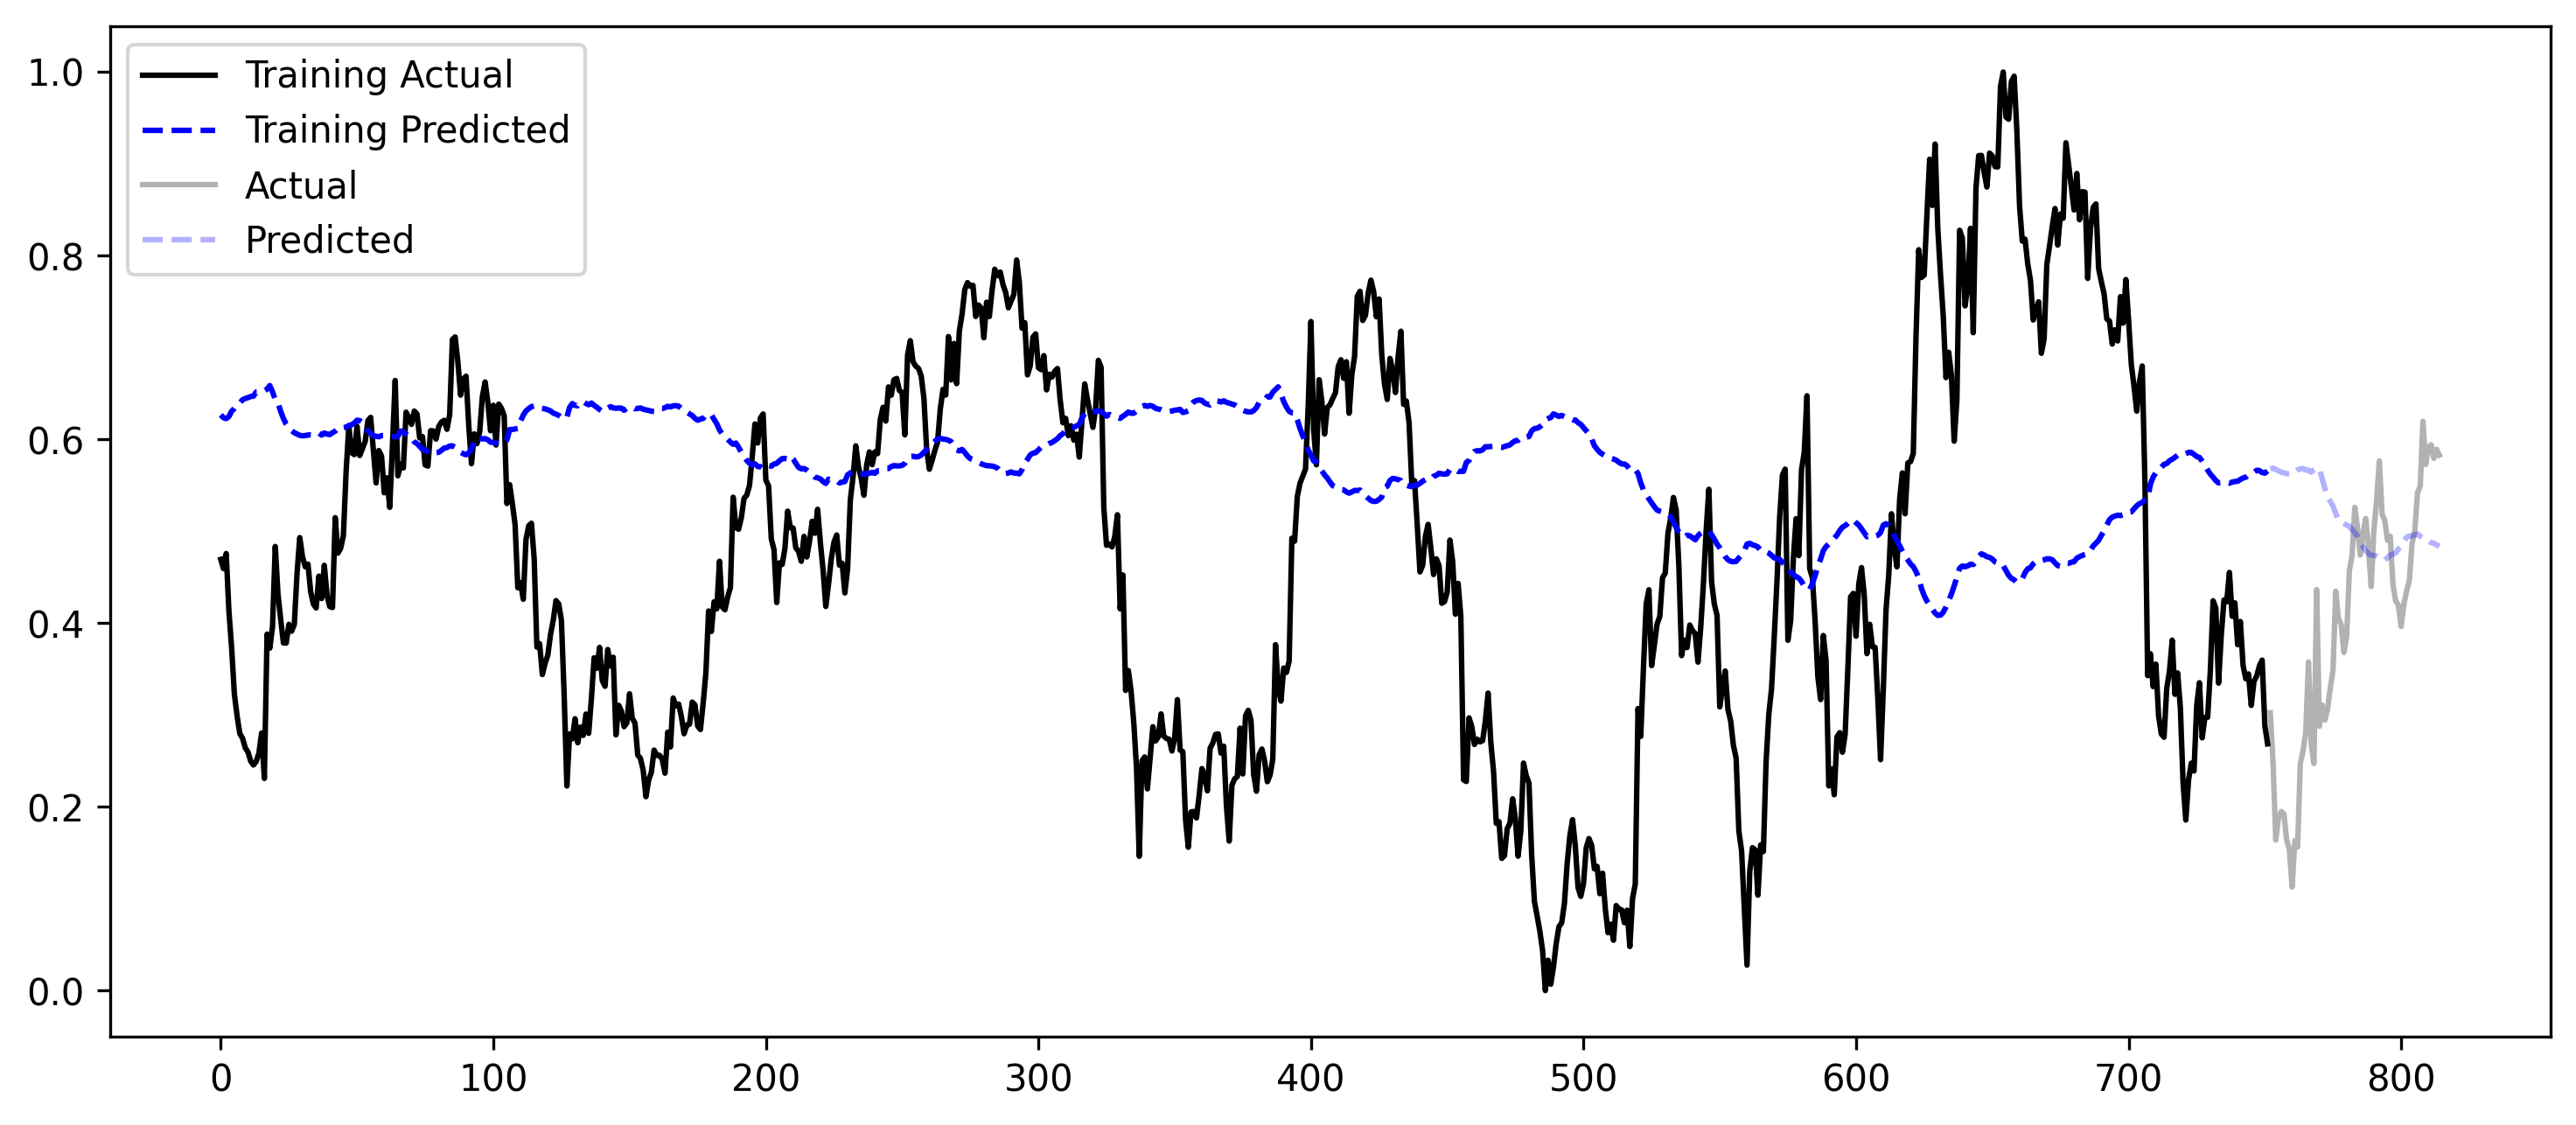

In [82]:
# load the best model
model.load_state_dict(torch.load('model.pt'))

# make predictions
model.eval()  # set the model to evaluation mode

y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred = model(X_batch.to(pytorch_device))
        y_pred.append(y_test_pred.cpu().numpy())
        y_true.append(y_batch.numpy())

y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

y_train_preds = []
y_train_true = []
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        y_train_pred = model(X_batch.to(pytorch_device))
        y_train_preds.append(y_train_pred.cpu().numpy())
        y_train_true.append(y_batch.numpy())

y_train_pred = np.concatenate(y_train_preds)
y_train_true = np.concatenate(y_train_true)

# plot the predictions and the real values
# also plot the training data, both real and predicted
plt.figure(figsize=(12, 5), dpi=300)
plt.plot(y_train_true, label='Training Actual', color='black')
plt.plot(y_train_pred, label='Training Predicted', color='blue', linestyle='--')
plt.plot( range( len(y_train_pred), len(y_train_pred) + len(y_pred) ), y_true, color='black', alpha=0.3, label='Actual')
plt.plot( range( len(y_train_pred), len(y_train_pred) + len(y_pred) ), y_pred, color='blue', alpha=0.3, label='Predicted', linestyle='--' )
plt.legend()

#### *Gridsearch for tuning*

In [184]:
hidden_sizes = [16, 32, 48]
lrs = [0.0001, 0.001]
dropouts = [0.2, 0.3, 0.4]
num_layers = [1, 2]
num_epochs = 50

# Create the nested dictionary structure
hyperparameters_dict = {}

# Define the nested loops for each hyperparameter
for h_size in hidden_sizes:
    for lr in lrs:
        for dropout in dropouts:
            for num_layer in num_layers:
                
                # create a new LSTM model with the specific hyperparameters
                model = LSTM(input_size, h_size, num_layer, output_size, dropout)
                model = model.to(pytorch_device)  # move model to GPU if available

                # specify loss function and optimizer
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # train the model (with your training function)
                epoch_train_losses, epoch_val_losses, min_val_loss = train_model(model=model,
                                                                                 train_loader=train_loader, test_loader=test_loader,
                                                                                 criterion=criterion, optimizer=optimizer, 
                                                                                 num_epochs=num_epochs)
                # Save the model and its performance metrics
                metrics = {'model': model,
                           'train_losses': epoch_train_losses,
                           'val_losses': epoch_val_losses,
                           'min_train_loss': epoch_train_losses[-1],
                           'min_val_loss': min_val_loss,}

                # Update the hyperparameters dictionary
                print(f'Hidden size: {h_size}, Learning rate: {lr}, Dropout: {dropout}, Number of layers: {num_layer}')
                key = f'h_s{h_size}_lr{lr}_d_o{dropout}_n_l{num_layer}'
                hyperparameters_dict[key] = metrics

c:\Users\Simon\OneDrive\DTU\8.sem\BachelorProject\shared\.venv\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\Simon\OneDrive\DTU\8.sem\BachelorProject\shared\.venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Simon\OneDrive\DTU\8.sem\BachelorProject\shared\.venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due t

Epoch 1/50.. Train loss: 0.621, Validation loss: 0.799
Validation loss decreased (inf --> 0.798602).  Saving model ...
Epoch 2/50.. Train loss: 0.527, Validation loss: 0.648
Validation loss decreased (0.798602 --> 0.648213).  Saving model ...
Epoch 3/50.. Train loss: 0.443, Validation loss: 0.512
Validation loss decreased (0.648213 --> 0.512450).  Saving model ...
Epoch 4/50.. Train loss: 0.368, Validation loss: 0.387
Validation loss decreased (0.512450 --> 0.386791).  Saving model ...
Epoch 5/50.. Train loss: 0.292, Validation loss: 0.273
Validation loss decreased (0.386791 --> 0.273397).  Saving model ...
Epoch 6/50.. Train loss: 0.227, Validation loss: 0.179
Validation loss decreased (0.273397 --> 0.179309).  Saving model ...
Epoch 7/50.. Train loss: 0.169, Validation loss: 0.112
Validation loss decreased (0.179309 --> 0.111966).  Saving model ...
Epoch 8/50.. Train loss: 0.131, Validation loss: 0.072
Validation loss decreased (0.111966 --> 0.071605).  Saving model ...
Epoch 9/50.. 

c:\Users\Simon\OneDrive\DTU\8.sem\BachelorProject\shared\.venv\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/50.. Train loss: 0.736, Validation loss: 0.752
Validation loss decreased (inf --> 0.751969).  Saving model ...
Epoch 2/50.. Train loss: 0.646, Validation loss: 0.628
Validation loss decreased (0.751969 --> 0.628104).  Saving model ...
Epoch 3/50.. Train loss: 0.560, Validation loss: 0.505
Validation loss decreased (0.628104 --> 0.505051).  Saving model ...
Epoch 4/50.. Train loss: 0.462, Validation loss: 0.387
Validation loss decreased (0.505051 --> 0.387487).  Saving model ...
Epoch 5/50.. Train loss: 0.374, Validation loss: 0.282
Validation loss decreased (0.387487 --> 0.282010).  Saving model ...
Epoch 6/50.. Train loss: 0.288, Validation loss: 0.196
Validation loss decreased (0.282010 --> 0.196392).  Saving model ...
Epoch 7/50.. Train loss: 0.209, Validation loss: 0.133
Validation loss decreased (0.196392 --> 0.132636).  Saving model ...
Epoch 8/50.. Train loss: 0.152, Validation loss: 0.090
Validation loss decreased (0.132636 --> 0.089633).  Saving model ...
Epoch 9/50.. 

c:\Users\Simon\OneDrive\DTU\8.sem\BachelorProject\shared\.venv\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/50.. Train loss: 0.431, Validation loss: 0.530
Validation loss decreased (inf --> 0.529864).  Saving model ...
Epoch 2/50.. Train loss: 0.366, Validation loss: 0.439
Validation loss decreased (0.529864 --> 0.438706).  Saving model ...
Epoch 3/50.. Train loss: 0.315, Validation loss: 0.347
Validation loss decreased (0.438706 --> 0.347108).  Saving model ...
Epoch 4/50.. Train loss: 0.243, Validation loss: 0.251
Validation loss decreased (0.347108 --> 0.251282).  Saving model ...
Epoch 5/50.. Train loss: 0.180, Validation loss: 0.160
Validation loss decreased (0.251282 --> 0.160471).  Saving model ...
Epoch 6/50.. Train loss: 0.128, Validation loss: 0.092
Validation loss decreased (0.160471 --> 0.092055).  Saving model ...
Epoch 7/50.. Train loss: 0.095, Validation loss: 0.057
Validation loss decreased (0.092055 --> 0.057401).  Saving model ...
Epoch 8/50.. Train loss: 0.078, Validation loss: 0.047
Validation loss decreased (0.057401 --> 0.046570).  Saving model ...
Epoch 9/50.. 

(0.025, 0.2)

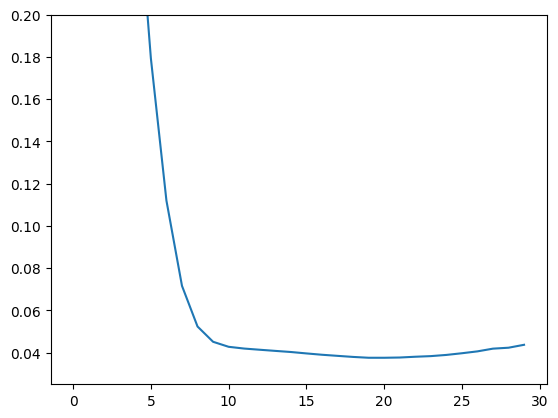

In [195]:
plt.plot(hyperparameters_dict['h_s16_lr0.0001_d_o0.2_n_l1']['val_losses'])
plt.ylim(0.025, 0.2)

In [199]:
min_value = float('inf')
min_key = None

# Iterate over the outer dictionary
for outer_key, inner_dict in hyperparameters_dict.items():
    # Iterate over the inner dictionary
    value = inner_dict['min_val_loss']
    if value < min_value:
        min_value = value
        min_key = outer_key

# Print the minimum value and key
print(f"Minimum value: {min_value}")
print(f"Key: {min_key}")

Minimum value: 0.03755656536668539
Key: h_s16_lr0.0001_d_o0.2_n_l1


In [ ]:
"""
For training on GPU

pin_memory = True
num_workers = 4

# load the data into the cuda device
# in your training loop
for batch_X, batch_y in dataloader:
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)


"""

In [234]:
# estimated FLOPS
s_l = 63
n_l = 2
b_s = 32
i_s = 6
h_s = 32
o_s = 1

epochs = 50
n_ti = 500

total_FLOP_per_batch = s_l * n_l * b_s * 4 * 2 * (i_s + h_s) * h_s + 2 * b_s * i_s * o_s
print(f"Total FLOP per batch:\t\t{total_FLOP_per_batch}")
# number of samples, and also the number of times the model has to load batches
n_samples = 879
n_batches = np.ceil(n_samples / b_s)

total_FLOP_per_epoch = int(total_FLOP_per_batch * n_batches * 10)
print(f"Total FLOP per epoch:\t\t{total_FLOP_per_epoch}")

total_FLOP_per_model = total_FLOP_per_epoch * epochs
print(f"Total FLOP per model:\t\t{total_FLOP_per_model}")

total_FLOP = total_FLOP_per_model * n_ti
print(f"Total FLOP in all:\t\t{total_FLOP}")

# terraflops is 10^12 FLOPs - A100 has 312 terraflops
A100_FLOPs = 312*10**12
simon_FLOPS = 285.4 * 10**9

print(f"A100 GPU FLOPs:  \t\t{A100_FLOPs}")
print(f"Simon's GPU FLOPs:\t\t{simon_FLOPS}")

# estimated training time
print(f"Estimated training time:\t{total_FLOP / A100_FLOPs /60} minutes")
print(f"Estimated training time:\t{total_FLOP / simon_FLOPS /60} minutes")

print(f"Actual time for finishing one(1) model on simon \t{41} seconds")

performance_ratio = 
r = simon_FLOPS / A100_FLOPs
print(f"The ratio between A100 and simon is \t\t\t{r}")
print(f"So the estimated time on A100 for 500 models is \t{41 * r * 500} seconds")
print(f"and for simon it would be \t\t\t\t{41 * 500 / 60} minutes")

print(f"Estimated time for doing grid search A100 \t\t{12 * 500 * r*60} seconds")

Total FLOP per batch:		39223680
Total FLOP per epoch:		10982630400
Total FLOP per model:		549131520000
Total FLOP in all:		274565760000000
A100 GPU FLOPs:  		312000000000000
Simon's GPU FLOPs:		285400000000.0
Estimated training time:	0.014666974358974358 minutes
Estimated training time:	16.03397337070778 minutes
Actual time for finishing one(1) model on simon 	41 seconds
The ratio between A100 and simon is 			0.0009147435897435898
So the estimated time on A100 for 500 models is 	18.75224358974359 seconds
and for simon it would be 				341.6666666666667 minutes
Estimated time for doing grid search A100 		329.3076923076923 seconds
